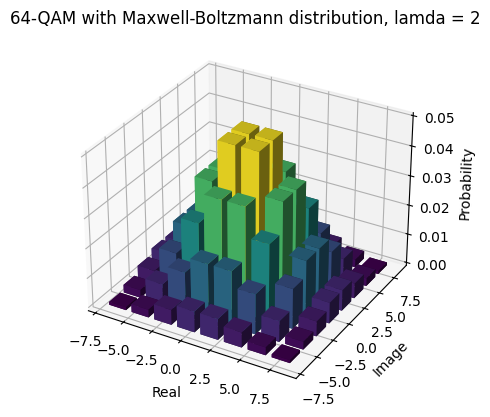

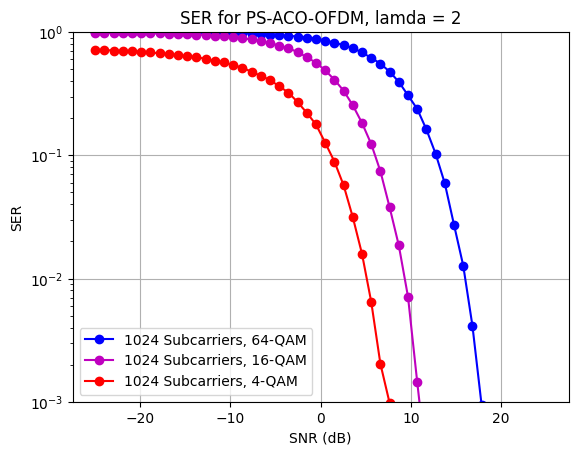

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import fsolve
from matplotlib import cm

class PS_ACO:
    def __init__(self, N, M, lamda):
        self.N = N #number of subcarriers
        self.M = M
        self.lamda = lamda
        self.mapping = self.create_mapping()
        self.x = (2*np.arange(1, int(np.sqrt(self.M)) + 1)-int(np.sqrt(self.M)) -1)/(int(np.sqrt(self.M))-1)
        self.SNRdB = np.linspace(-25, 25)
        self.p_xm_pam = self.find_pxm_pam()
        self.E_av = self.find_E_av()
        self.pmf_qam = self.find_PMF_QAM()
        self.constel = self.find_constel_qam()
        self.symbol_mapped = self.find_symbol_mapped()
        self.data = self.reverse_map(self.symbol_mapped)
        self.HermittianSymetry = self.hermitian_aco(self.symbol_mapped, N)
        self.AfterIFFT = self.IFFT(self.HermittianSymetry)
        self.AfterClipping = self.Clipping(self.AfterIFFT)
        self.demapping_table = {v: k for k, v in self.mapping.items()}
    
    def find_constel_qam(self):
        constel_table = np.zeros((int(np.sqrt(self.M)), int(np.sqrt(self.M))), dtype=complex)
        for r in range(int(np.sqrt(self.M))):
            for c in range(int(np.sqrt(self.M))):
                constel_table[r][c] = ((2*c+1-np.sqrt(self.M)) - 1j*(2*r+1-np.sqrt(self.M))) 
        return constel_table
    
    def gray_code(self, n):
        return [i ^ (i >> 1) for i in range(2 ** n)]

    def bits_to_tuple(self, bits, n):
        return tuple(map(int, format(bits, f'0{n}b')))
    
    def create_mapping(self):
        constel_table = self.find_constel_qam()
        bits_per_dim = int(np.log2(int(np.sqrt(self.M))))
        real_gray = self.gray_code(bits_per_dim)
        imag_gray = self.gray_code(bits_per_dim)
        mapping = {}
        for r in range(int(np.sqrt(self.M))):
            for c in range(int(np.sqrt(self.M))):
                real_bits = self.bits_to_tuple(real_gray[c], bits_per_dim)
                imag_bits = self.bits_to_tuple(imag_gray[r], bits_per_dim)
                bit_tuple = real_bits + imag_bits
                mapping[bit_tuple] = constel_table[r][c]
        return mapping

    def reverse_map(self, symbol_mapped):
        reverse_mapping = {v: k for k, v in self.mapping.items()}
        return np.concatenate([np.array(reverse_mapping[symbol]) for symbol in symbol_mapped])

    def calculate_ber(self):
      self.BER = []

      for snr_db in self.SNRdB:
          ber_iteration = []

          for _ in range(100):
              self.ACO_RX = self.channel(self.AfterClipping, snr_db)
              self.AfterFFT = self.FFT(self.ACO_RX)
              self.symbol_ext = self.message_ext(self.AfterFFT)
              self.Afterdemap, _ = self.demapping(self.symbol_ext, self.demapping_table)
              self.dataouput = self.P_S(self.Afterdemap)
              ber_iteration.append(np.mean(self.data != self.dataouput))


          self.BER.append(np.mean(ber_iteration))

    def find_pxm_pam(self):
        p_xm = np.zeros(int(np.sqrt(self.M)))
        SIGMA = 0
        for i in range(int(np.sqrt(self.M))):
            SIGMA += np.exp(-self.x[i]**2*self.lamda)
        for i in range(int(np.sqrt(self.M))):
            p_xm[i] = np.exp(-self.x[i]**2*self.lamda)/SIGMA
        return p_xm
    
    def find_E_av(self):
        Av = 0
        for i in range(int(np.sqrt(self.M))):
            Av += self.x[i]**2*self.p_xm_pam[i]
        return Av
    
    def find_PMF_QAM(self):
        PMF_QAM = np.zeros((int(np.sqrt(self.M)), int(np.sqrt(self.M))))
        for i in range(int(np.sqrt(self.M))):
            for j in range(int(np.sqrt(self.M))):
                PMF_QAM[i,j] = np.transpose(self.p_xm_pam[i])*self.p_xm_pam[j]
        return PMF_QAM
    
    
    
    def find_symbol_mapped(self):
        pmf_qam = self.pmf_qam.flatten()
        constel = self.constel.flatten()
        symbols = np.random.choice(constel, size = self.N//4, p = pmf_qam)
        return symbols
    
    def hermitian_aco(self, symbol_mapped, K):
        SYMETRICarray = np.zeros(K, dtype=complex)

        odd_index = 1
        for i in range(len(symbol_mapped)):
            if odd_index < K // 2:
                SYMETRICarray[odd_index] = symbol_mapped[i]
                SYMETRICarray[K - odd_index] = np.conjugate(symbol_mapped[i])
                odd_index += 2
        return SYMETRICarray

    def IFFT(self, HermittianSymetry):
        return np.fft.ifft(HermittianSymetry)
    
    def Clipping(self, AfterIFFT):
        clippedsignal = np.maximum(AfterIFFT, 0)
        return clippedsignal

    def channel(self, signal, snr_db):
        Channel_response = np.array([1])
        Y = np.convolve(signal, Channel_response)[:len(signal)]
        signal_power = np.mean(np.abs(Y) ** 2)
        noise_power = signal_power * 10 ** (-snr_db / 10)
        noise = np.sqrt(noise_power / 2) * np.random.randn(*Y.shape)
        return Y + noise
    
    def FFT(self, ACO_RX):
        return np.fft.fft(ACO_RX)

    def message_ext(self, AfterFFT):
        symbol_ext = []
        for i in range(len(AfterFFT)//2):
            if i % 2 != 0:
                symbol_ext.append(2 * AfterFFT[i])
        return np.array(symbol_ext)
    
    def demapping(self, mapping, demapping_table):
        constel = np.array([x for x in demapping_table.keys()])
        dis = abs(mapping.reshape((-1, 1)) - constel.reshape((1, -1)))
        constel_index = dis.argmin(axis=1)
        HDecision = constel[constel_index]
        return np.vstack([demapping_table[C] for C in HDecision]), HDecision

    def P_S(self, bits):
        return bits.reshape((-1,))
    
    def calculate_ser(self):
        self.SER = []

        for snr_db in self.SNRdB:
            ser_iteration = []

            for _ in range(100):
                self.ACO_RX = self.channel(self.AfterClipping, snr_db)
                self.AfterFFT = self.FFT(self.ACO_RX)
                self.symbol_ext = self.message_ext(self.AfterFFT)
                self.Afterdemap, decision_symbols = self.demapping(self.symbol_ext, self.demapping_table)
                symbol_errors = np.mean(self.symbol_mapped != decision_symbols)
                ser_iteration.append(symbol_errors)

            self.SER.append(np.mean(ser_iteration))
    
    def plot_PMF_QAM(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xpos, ypos = np.meshgrid(self.x, self.x)
        xpos = xpos.flatten()*(int(np.sqrt(self.M))-1)
        ypos = ypos.flatten()*(int(np.sqrt(self.M))-1)
        zpos = np.zeros_like(xpos)
        
        dx = dy = 1.5
        dz = self.pmf_qam.flatten()  

        
        norm = plt.Normalize(dz.min(), dz.max())
        colors = cm.viridis(norm(dz))

        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, shade=True)
        
        ax.set_xlabel('Real')
        ax.set_ylabel('Image')
        ax.set_zlabel('Probability')

        plt.title(f'64-QAM with Maxwell-Boltzmann distribution, lamda = {self.lamda}')
        plt.show()

    def plot_demapped_constellation(self):
        self.ACO_RX = self.channel(self.AfterClipping, 0)  # giả sử snr = 0 dB
        self.AfterFFT = self.FFT(self.ACO_RX)
        self.symbol_ext = self.message_ext(self.AfterFFT)
        demapped_symbols, mapped_constellation = self.demapping(self.symbol_ext, self.demapping_table)
        
        plt.figure(figsize=(10, 10))
        
        for bits, symbol in zip(demapped_symbols, self.symbol_ext):
            plt.plot(symbol.real, symbol.imag, 'ro')  
        
        for bits, constellation_point in self.mapping.items():
            bit_label = ''.join(map(str, bits))
            plt.plot(constellation_point.real, constellation_point.imag, 'bo')  
            plt.text(constellation_point.real + 0.2, constellation_point.imag, f'{bit_label}', fontsize=9, ha='center', va='center')
        
        for symbol, constellation_point in zip(self.symbol_ext, mapped_constellation):
            plt.plot([symbol.real, constellation_point.real], [symbol.imag, constellation_point.imag], 'g-', alpha=0.6)
        plt.title('Demapped Constellation Diagram at SNR = 0')
        plt.grid(True)
        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.xlim([-np.sqrt(self.M), np.sqrt(self.M)])
        plt.ylim([-np.sqrt(self.M), np.sqrt(self.M)])
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.show()


Cam = PS_ACO(1024, 64, 2)
Pink = PS_ACO(1024, 16, 2)
Cam1 = PS_ACO(1024, 4, 2)
# Cam.plot_demapped_constellation()
# Pink.plot_demapped_constellation()
# Cam1.plot_demapped_constellation()
# Cam.calculate_ber()
# Pink.calculate_ber()
# Cam1.calculate_ber()
Cam.calculate_ser()
Pink.calculate_ser()
Cam1.calculate_ser()
Cam.plot_PMF_QAM()
# print(Cam.find_E_av())
# print(Pink.find_E_av())
# print(Cam1.find_E_av())



plt.ylim(10**-3,)
plt.plot(Cam.SNRdB, Cam.SER, 'bo-', label='1024 Subcarriers, 64-QAM')
plt.plot(Pink.SNRdB, Pink.SER, 'mo-', label='1024 Subcarriers, 16-QAM')
plt.plot(Cam1.SNRdB, Cam1.SER, 'ro-', label='1024 Subcarriers, 4-QAM')

plt.semilogy()
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.legend()
plt.title(f'SER for PS-ACO-OFDM, lamda = {Cam.lamda}')
plt.grid(True)
plt.show()
